In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


In [2]:
# Charger le dataset brut
df = pd.read_csv('../data/raw/electrical_consumption.csv')
print(f"Dataset original: {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Créer une copie pour la préparation
df_clean = df.copy()
print(f"Copie de travail créée: {df_clean.shape}")

Dataset original: 600 lignes, 34 colonnes
Copie de travail créée: (600, 34)


In [3]:
print("=" * 80)
print("SUPPRESSION DES DOUBLONS")
print("=" * 80)

duplicates_before = df_clean.duplicated().sum()
print(f"Doublons détectés: {duplicates_before} ({duplicates_before/len(df_clean)*100:.2f}%)")

if duplicates_before > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"✓ Doublons supprimés")
    print(f"Nouvelle taille: {df_clean.shape[0]} lignes")
else:
    print("✓ Aucun doublon à supprimer")

SUPPRESSION DES DOUBLONS
Doublons détectés: 0 (0.00%)
✓ Aucun doublon à supprimer


In [4]:
print("\n" + "=" * 80)
print("GESTION DES VALEURS MANQUANTES")
print("=" * 80)

missing_data = pd.DataFrame({
    'Colonne': df_clean.columns,
    'Valeurs manquantes': df_clean.isnull().sum(),
    'Pourcentage (%)': (df_clean.isnull().sum() / len(df_clean)) * 100
}).sort_values('Pourcentage (%)', ascending=False)

missing_data = missing_data[missing_data['Valeurs manquantes'] > 0]

if len(missing_data) > 0:
    display(missing_data)
else:
    print("✓ Aucune valeur manquante détectée")


GESTION DES VALEURS MANQUANTES


,Colonne,Valeurs manquantes,Pourcentage (%)
insolation,insolation,267,44.500000
totalkW_w/1,totalkW_w/1,7,1.166667
totalkW_w-1,totalkW_w-1,7,1.166667
totalkW_d-1,totalkW_d-1,1,0.166667
totalkW_d/1,totalkW_d/1,1,0.166667


In [5]:

cols_to_drop = missing_data[missing_data['Pourcentage (%)'] > 50]['Colonne'].tolist()
if cols_to_drop:
    print(f"\nSuppression des colonnes avec >50% de valeurs manquantes: {cols_to_drop}")
    df_clean = df_clean.drop(columns=cols_to_drop)

numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_missing = [col for col in numeric_cols if df_clean[col].isnull().sum() > 0]

if numeric_missing:
    print(f"\nImputation des variables numériques: {numeric_missing}")
    print("Stratégie: Médiane (robuste aux outliers)")
    
    for col in numeric_missing:
        median_value = df_clean[col].median()
        df_clean[col].fillna(median_value, inplace=True)
        print(f"  - {col}: rempli avec médiane = {median_value:.2f}")

categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
categorical_missing = [col for col in categorical_cols if df_clean[col].isnull().sum() > 0]

if categorical_missing:
    print(f"\nImputation des variables catégorielles: {categorical_missing}")
    print("Stratégie: Mode (valeur la plus fréquente)")
    
    for col in categorical_missing:
        mode_value = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_value, inplace=True)
        print(f"  - {col}: rempli avec mode = '{mode_value}'")

print(f"\n✓ Valeurs manquantes après traitement: {df_clean.isnull().sum().sum()}")


Imputation des variables numériques: ['totalkW_d-1', 'totalkW_w-1', 'totalkW_d/1', 'totalkW_w/1', 'insolation']
Stratégie: Médiane (robuste aux outliers)
  - totalkW_d-1: rempli avec médiane = -2.52
  - totalkW_w-1: rempli avec médiane = 1.08
  - totalkW_d/1: rempli avec médiane = 0.99
  - totalkW_w/1: rempli avec médiane = 1.00
  - insolation: rempli avec médiane = 5.50

✓ Valeurs manquantes après traitement: 283


In [6]:
print("\n" + "=" * 80)
print("TRAITEMENT DES OUTLIERS")
print("=" * 80)

def detect_outliers_iqr(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return lower_bound, upper_bound

print("Stratégie: Winsorization (plafonnement des valeurs extrêmes)\n")

numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
outliers_count_before = 0

for col in numeric_cols:
    lower_bound, upper_bound = detect_outliers_iqr(df_clean, col)
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outliers_count_before += len(outliers)
    
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df_clean)*100:.2f}%)")
        
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
        print(f"  → Valeurs plafonnées entre [{lower_bound:.2f}, {upper_bound:.2f}]")

print(f"\n✓ Total outliers traités: {outliers_count_before}")



TRAITEMENT DES OUTLIERS
Stratégie: Winsorization (plafonnement des valeurs extrêmes)

totalkW_d-1: 173 outliers (28.83%)
  → Valeurs plafonnées entre [-70.12, 65.08]
totalkW_w-1: 61 outliers (10.17%)
  → Valeurs plafonnées entre [-69.94, 72.46]
totalkW_d/1: 175 outliers (29.17%)
  → Valeurs plafonnées entre [0.77, 1.21]
totalkW_w/1: 61 outliers (10.17%)
  → Valeurs plafonnées entre [0.77, 1.25]
HDD_25: 7 outliers (1.17%)
  → Valeurs plafonnées entre [-3.75, 13.45]
NWD: 17 outliers (2.83%)
  → Valeurs plafonnées entre [0.00, 0.00]
temp_max: 2 outliers (0.33%)
  → Valeurs plafonnées entre [14.39, 38.89]
temp_mean: 3 outliers (0.50%)
  → Valeurs plafonnées entre [11.45, 30.61]
RH: 4 outliers (0.67%)
  → Valeurs plafonnées entre [42.00, 106.00]

✓ Total outliers traités: 503


In [7]:
print("\n" + "=" * 80)
print("ENCODAGE DES VARIABLES CATÉGORIELLES")
print("=" * 80)

categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols:
    print(f"Variables catégorielles à encoder: {categorical_cols}\n")
    
    for col in categorical_cols:
        unique_values = df_clean[col].nunique()
        
        if unique_values == 2:
            print(f"{col}: Label Encoding (binaire)")
            le = LabelEncoder()
            df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])
            print(f"  Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
        
        elif unique_values <= 10:
            print(f"{col}: One-Hot Encoding ({unique_values} catégories)")
            dummies = pd.get_dummies(df_clean[col], prefix=col, drop_first=True)
            df_clean = pd.concat([df_clean, dummies], axis=1)
            print(f"  Nouvelles colonnes créées: {list(dummies.columns)}")
        
        else:
            print(f"{col}: Trop de catégories ({unique_values})")
            print(f"  Stratégie recommandée: Regroupement ou Target Encoding")
    
    print(f"\nSuppression des colonnes catégorielles originales: {categorical_cols}")
    df_clean = df_clean.drop(columns=categorical_cols)
    
    print(f"✓ Encodage terminé. Nouvelles dimensions: {df_clean.shape}")
else:
    print("✓ Aucune variable catégorielle à encoder")


ENCODAGE DES VARIABLES CATÉGORIELLES
Variables catégorielles à encoder: ['Date', '53_kW_time_max', '71_kW_time_max', '71A_kW_time_max', '83_kW_time_max', '71_71AkW_time_max', 'totalkW_time_max']

Date: Trop de catégories (600)
  Stratégie recommandée: Regroupement ou Target Encoding
53_kW_time_max: Trop de catégories (24)
  Stratégie recommandée: Regroupement ou Target Encoding
71_kW_time_max: Trop de catégories (21)
  Stratégie recommandée: Regroupement ou Target Encoding
71A_kW_time_max: Trop de catégories (23)
  Stratégie recommandée: Regroupement ou Target Encoding
83_kW_time_max: Trop de catégories (21)
  Stratégie recommandée: Regroupement ou Target Encoding
71_71AkW_time_max: Trop de catégories (23)
  Stratégie recommandée: Regroupement ou Target Encoding
totalkW_time_max: Trop de catégories (24)
  Stratégie recommandée: Regroupement ou Target Encoding

Suppression des colonnes catégorielles originales: ['Date', '53_kW_time_max', '71_kW_time_max', '71A_kW_time_max', '83_kW_time

In [8]:
print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

print("Note: Adaptez cette section selon les insights de votre EDA")


FEATURE ENGINEERING
Note: Adaptez cette section selon les insights de votre EDA


In [9]:
print("\n" + "=" * 80)
print("NORMALISATION / STANDARDISATION")
print("=" * 80)

target_variable = 'totalkW_mean'  

if target_variable in df_clean.columns:
    X = df_clean.drop(columns=[target_variable])
    y = df_clean[target_variable]
    print(f"✓ Variable cible trouvée: {target_variable}")
    print(f"Features (X): {X.shape}")
    print(f"Cible (y): {y.shape}")
else:
    print(f"⚠ Variable cible '{target_variable}' non trouvée dans le dataset")
    print(f"Colonnes disponibles: {list(df_clean.columns)}")
    
    X = df_clean
    y = None

print("\nStatistiques AVANT normalisation:")
display(X.describe().T[['mean', 'std', 'min', 'max']].head())


NORMALISATION / STANDARDISATION
✓ Variable cible trouvée: totalkW_mean
Features (X): (600, 26)
Cible (y): (600,)

Statistiques AVANT normalisation:


,mean,std,min,max
53_kW_mean,50.232383,9.492733,25.03,69.83
53_kW_max,63.342033,11.121755,35.96,94.57
71_kW_mean,52.907250,43.257855,0.00,133.48
71_kW_max,69.453117,58.276682,0.00,186.98
71A_kW_mean,135.962467,60.597422,48.11,273.10


In [10]:

print("\nStratégie: StandardScaler (Z-score normalization)")
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("\nStatistiques APRÈS standardisation:")
display(X_scaled.describe().T[['mean', 'std', 'min', 'max']].head())



Stratégie: StandardScaler (Z-score normalization)

Statistiques APRÈS standardisation:


,mean,std,min,max
53_kW_mean,2.190840e-16,1.000834,-2.657129,2.066209
53_kW_max,4.144833e-17,1.000834,-2.464079,2.810170
71_kW_mean,7.105427e-17,1.000834,-1.224087,1.864170
71_kW_max,0.000000e+00,1.000834,-1.192777,2.018388
71A_kW_mean,-7.105427e-17,1.000834,-1.450982,2.264980


In [11]:
print("\n" + "=" * 80)
print("SÉPARATION TRAIN / TEST")
print("=" * 80)

test_size = 0.2
random_state = 42  

if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=None  
    )
    
    print(f"Ensemble d'entraînement:")
    print(f"  X_train: {X_train.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"\nEnsemble de test:")
    print(f"  X_test: {X_test.shape}")
    print(f"  y_test: {y_test.shape}")
    
    print(f"\nRépartition: {len(X_train)} train ({len(X_train)/len(X_scaled)*100:.1f}%) / {len(X_test)} test ({len(X_test)/len(X_scaled)*100:.1f}%)")
else:
    print("⚠ Impossible de séparer: variable cible non définie")


SÉPARATION TRAIN / TEST
Ensemble d'entraînement:
  X_train: (480, 26)
  y_train: (480,)

Ensemble de test:
  X_test: (120, 26)
  y_test: (120,)

Répartition: 480 train (80.0%) / 120 test (20.0%)


In [12]:
print("\n" + "=" * 80)
print("SAUVEGARDE DES DONNÉES PRÉPARÉES")
print("=" * 80)

df_clean_full = pd.concat([X_scaled, y], axis=1) if y is not None else X_scaled
df_clean_full.to_csv('../data/processed/dataset_clean.csv', index=False)
print("✓ Dataset complet nettoyé: '../data/processed/dataset_clean.csv'")

if y is not None:
    X_train.to_csv('../data/processed/X_train.csv', index=False)
    X_test.to_csv('../data/processed/X_test.csv', index=False)
    y_train.to_csv('../data/processed/y_train.csv', index=False, header=True)
    y_test.to_csv('../data/processed/y_test.csv', index=False, header=True)
    
    print("✓ Ensembles d'entraînement et test sauvegardés:")
    print("  - X_train.csv, X_test.csv")
    print("  - y_train.csv, y_test.csv")

import joblib
joblib.dump(scaler, '../models/scaler.pkl')
print("✓ Scaler sauvegardé: '../models/scaler.pkl'")


SAUVEGARDE DES DONNÉES PRÉPARÉES
✓ Dataset complet nettoyé: '../data/processed/dataset_clean.csv'
✓ Ensembles d'entraînement et test sauvegardés:
  - X_train.csv, X_test.csv
  - y_train.csv, y_test.csv
✓ Scaler sauvegardé: '../models/scaler.pkl'


In [13]:
print("\n" + "=" * 80)
print("RÉSUMÉ DE LA PRÉPARATION DES DONNÉES")
print("=" * 80)

summary = f"""
Dataset original:
  - Lignes: {df.shape[0]:,}
  - Colonnes: {df.shape[1]}

Dataset final préparé:
  - Lignes: {X_scaled.shape[0]:,}
  - Colonnes (features): {X_scaled.shape[1]}

Transformations appliquées:
  ✓ Suppression des doublons
  ✓ Gestion des valeurs manquantes
  ✓ Traitement des outliers (Winsorization)
  ✓ Encodage des variables catégorielles
  ✓ Standardisation des features
  ✓ Séparation train/test ({test_size*100:.0f}% test)

Prêt pour la modélisation!
"""

print(summary)


RÉSUMÉ DE LA PRÉPARATION DES DONNÉES

Dataset original:
  - Lignes: 600
  - Colonnes: 34

Dataset final préparé:
  - Lignes: 600
  - Colonnes (features): 26

Transformations appliquées:
  ✓ Suppression des doublons
  ✓ Gestion des valeurs manquantes
  ✓ Traitement des outliers (Winsorization)
  ✓ Encodage des variables catégorielles
  ✓ Standardisation des features
  ✓ Séparation train/test (20% test)

Prêt pour la modélisation!



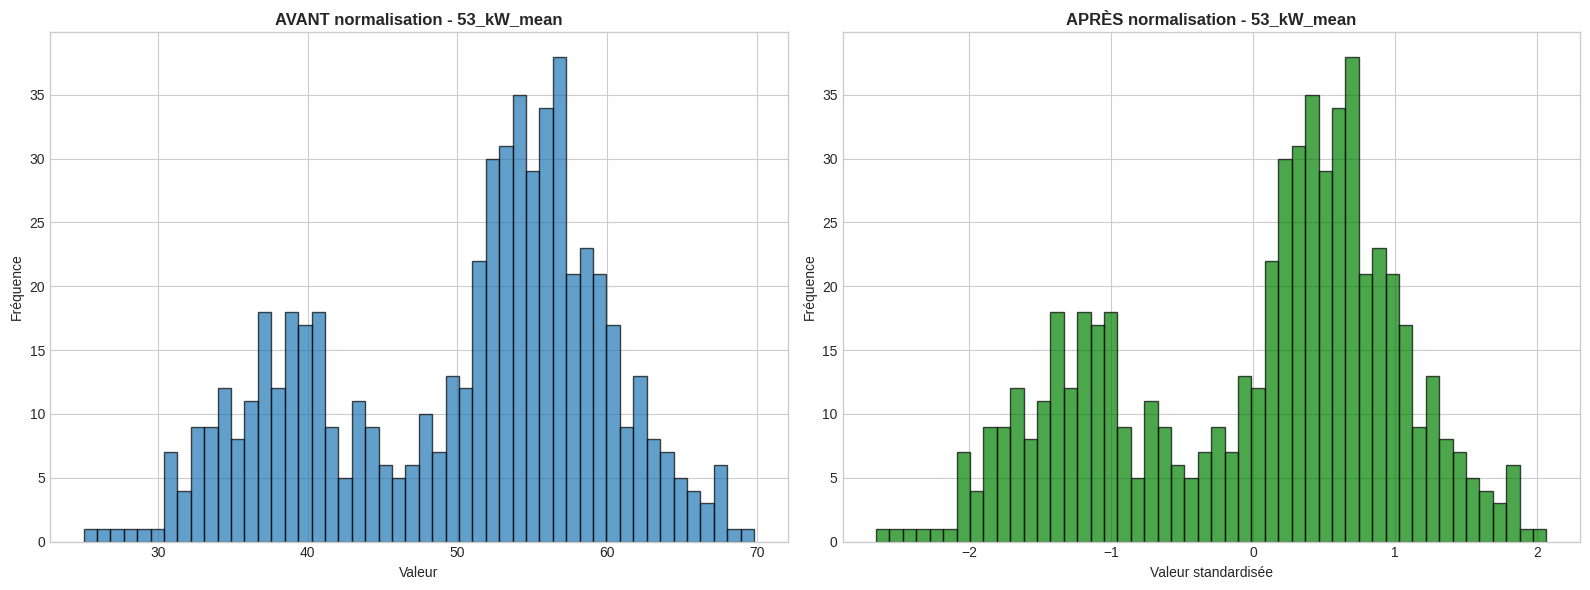

✓ Visualisation sauvegardée


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

example_col = X.columns[0]

axes[0].hist(X[example_col], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title(f'AVANT normalisation - {example_col}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Valeur')
axes[0].set_ylabel('Fréquence')

axes[1].hist(X_scaled[example_col], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'APRÈS normalisation - {example_col}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Valeur standardisée')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.savefig('../visualizations/normalisation_comparaison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualisation sauvegardée")